
1. ADIM: VERİ YÜKLEME

--- İlk 5 Satır ---
   Unnamed: 0   airline   flight source_city departure_time stops  \
0           0  SpiceJet  SG-8709       Delhi        Evening  zero   
1           1  SpiceJet  SG-8157       Delhi  Early_Morning  zero   
2           2   AirAsia   I5-764       Delhi  Early_Morning  zero   
3           3   Vistara   UK-995       Delhi        Morning  zero   
4           4   Vistara   UK-963       Delhi        Morning  zero   

    arrival_time destination_city    class  duration  days_left  price  
0          Night           Mumbai  Economy      2.17          1   5953  
1        Morning           Mumbai  Economy      2.33          1   5953  
2  Early_Morning           Mumbai  Economy      2.17          1   5956  
3      Afternoon           Mumbai  Economy      2.25          1   5955  
4        Morning           Mumbai  Economy      2.33          1   5955  

--- Veri Bilgisi (Info) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300

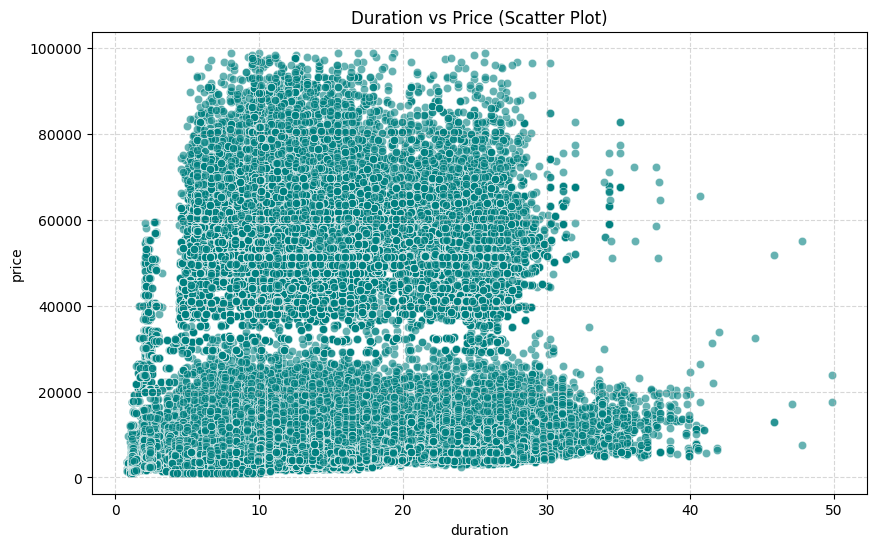

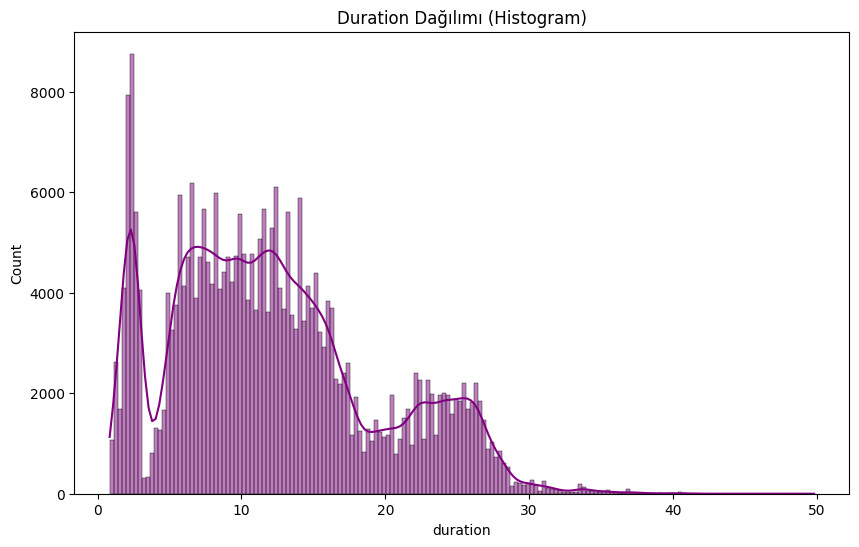

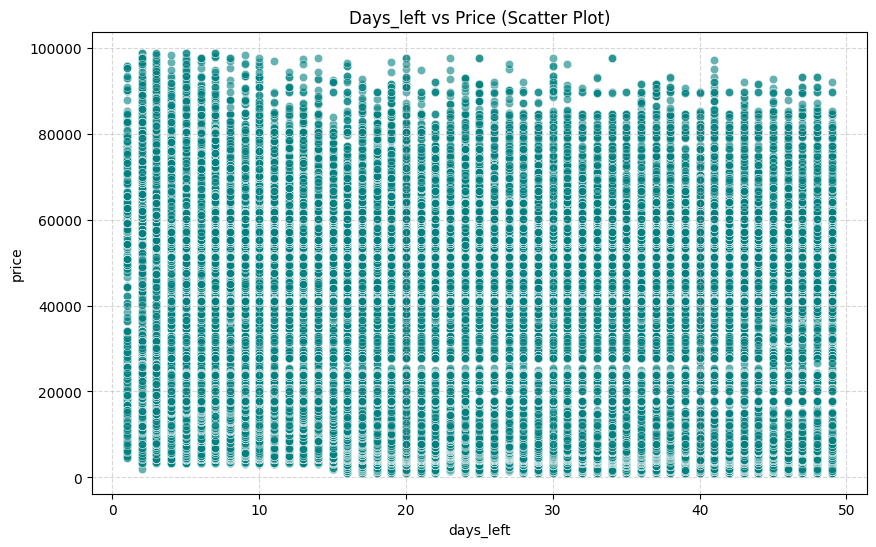

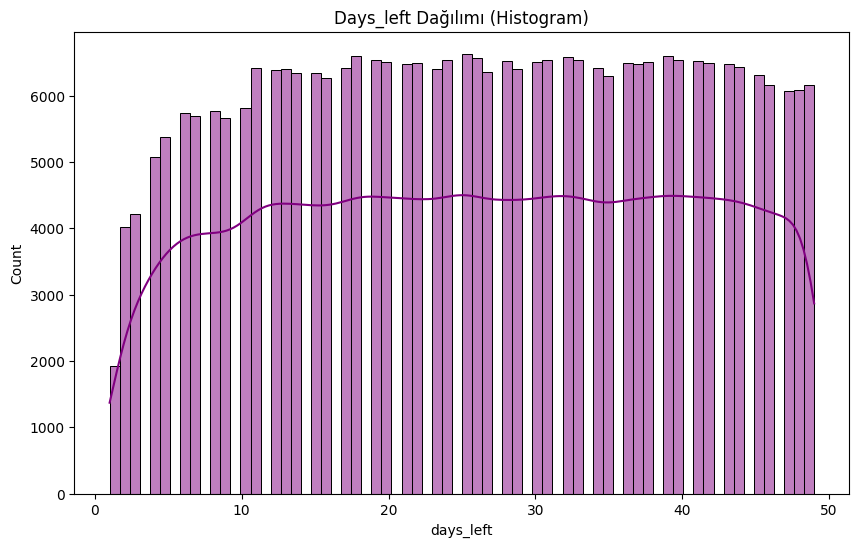

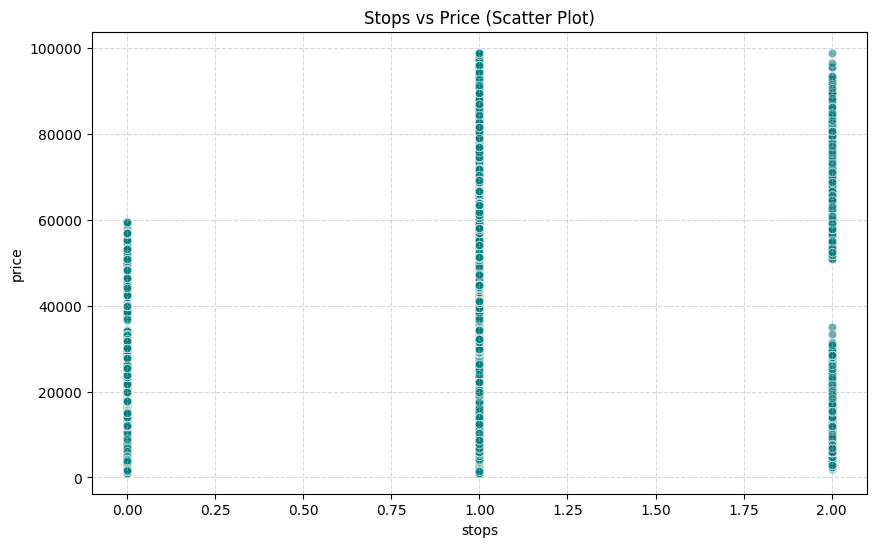

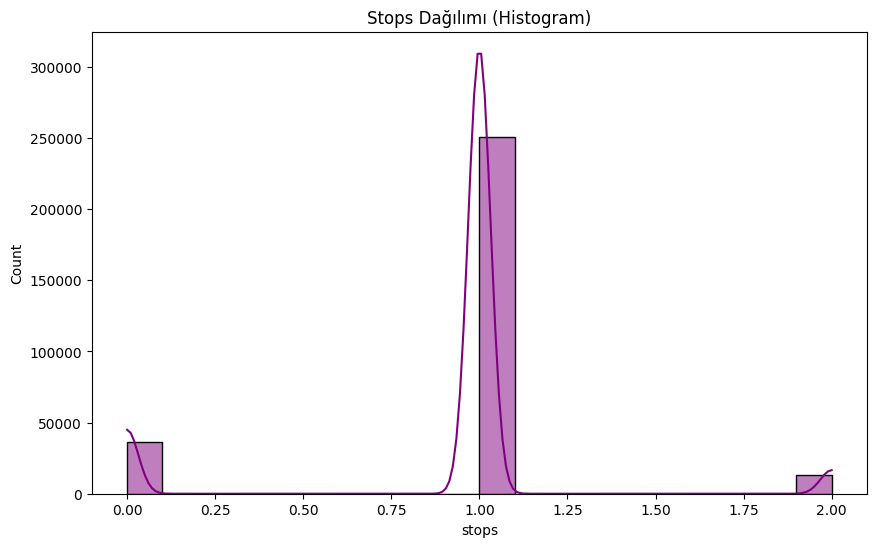

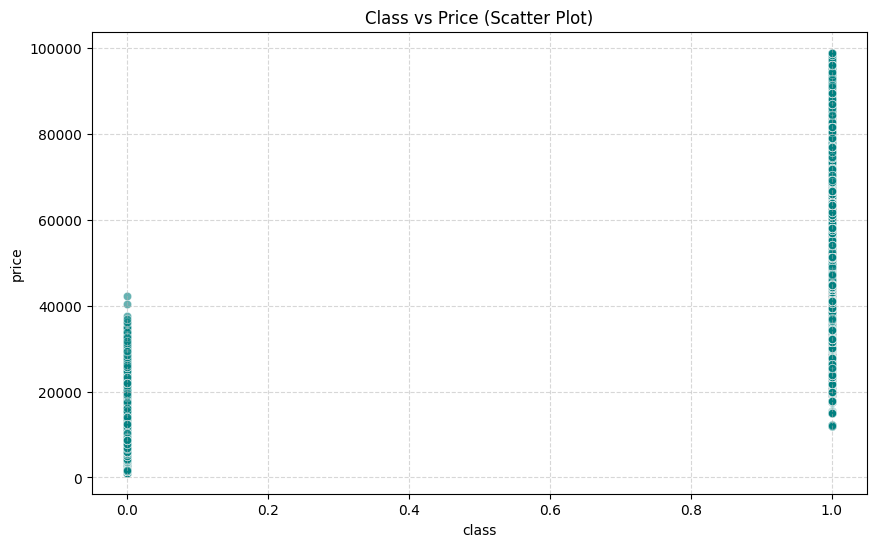

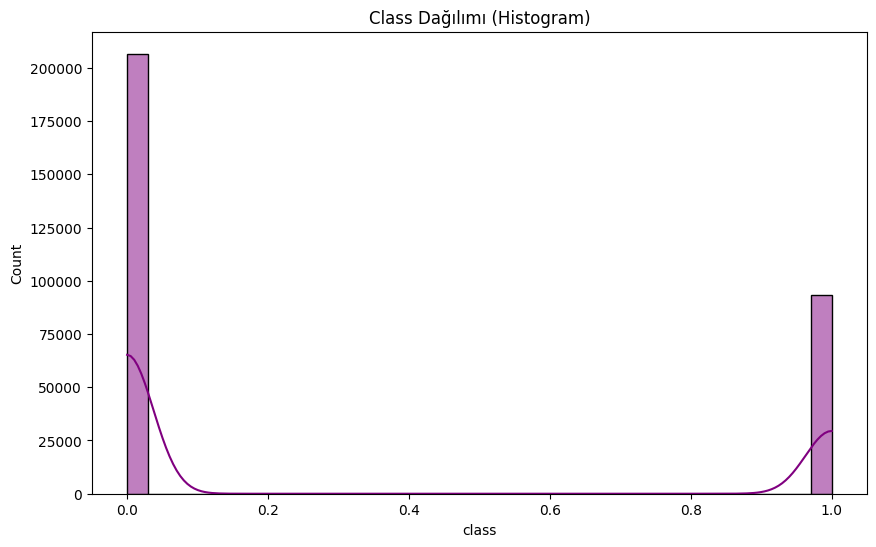

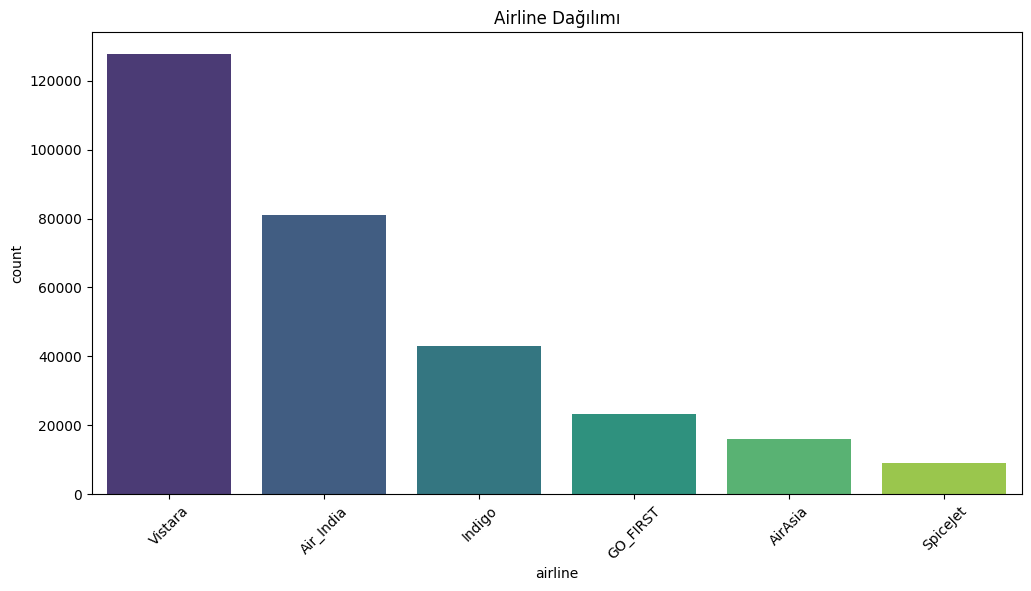

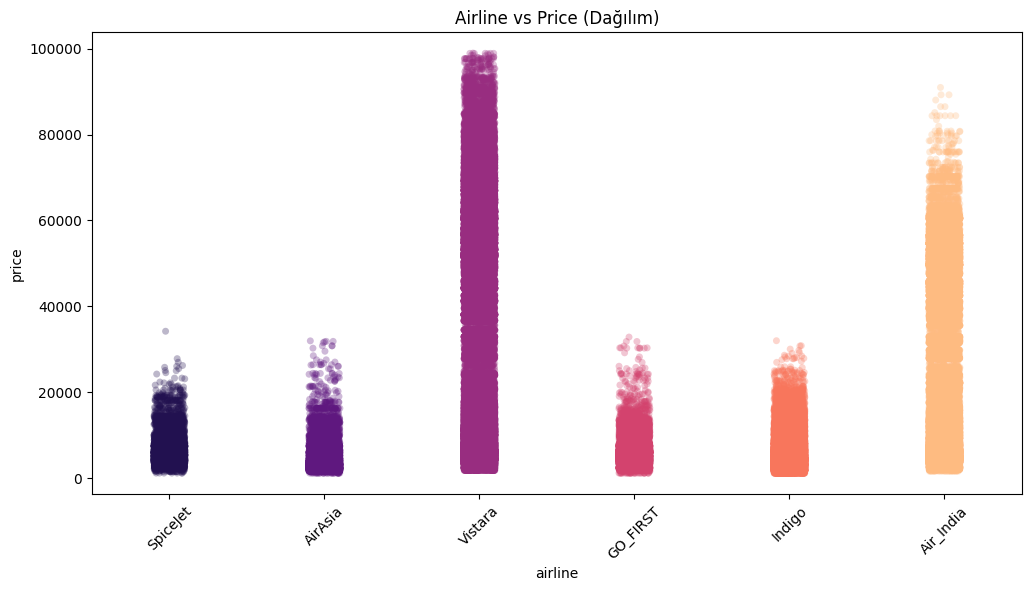

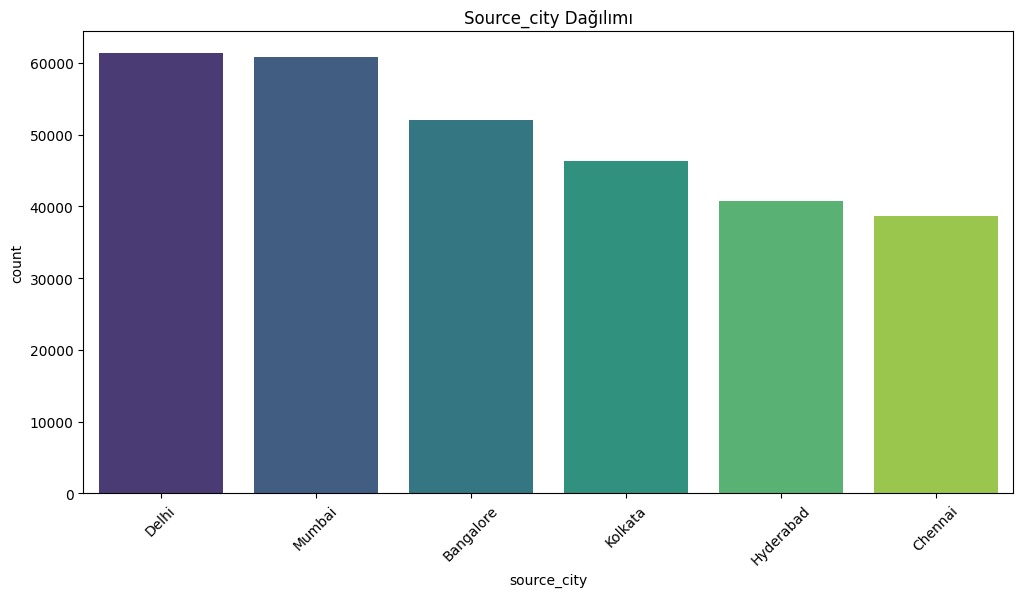

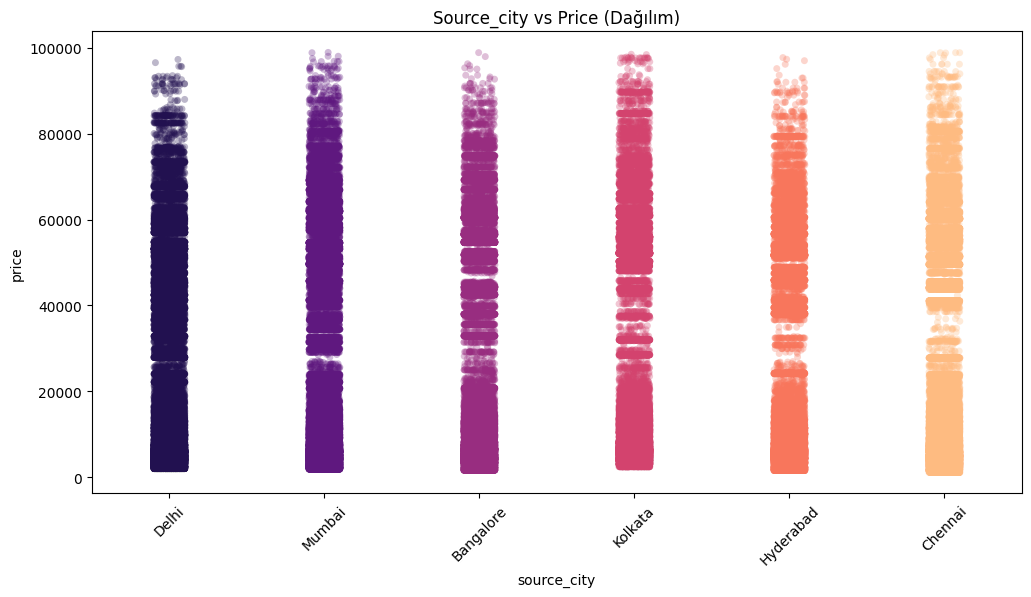

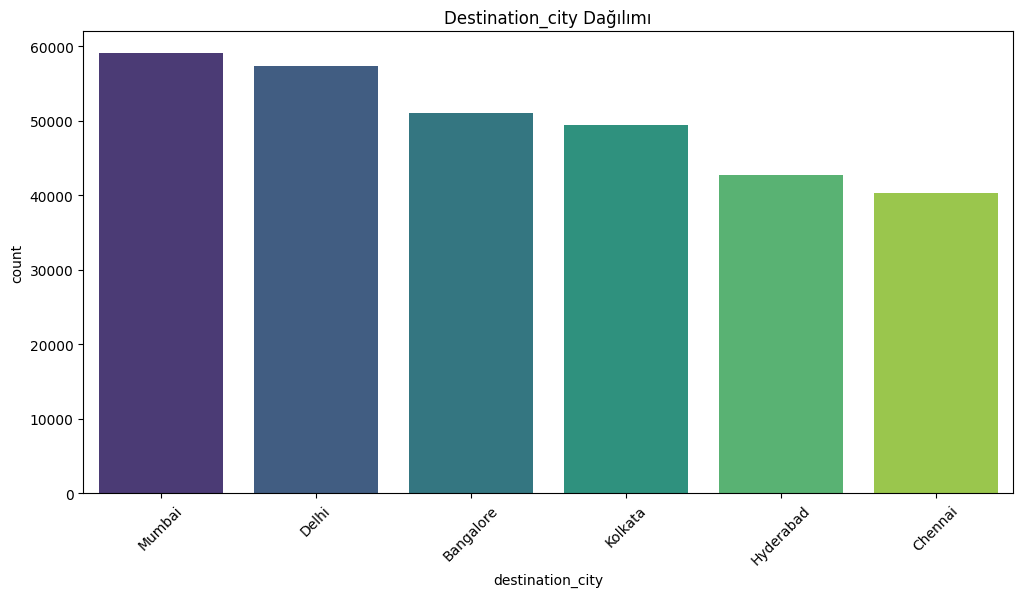

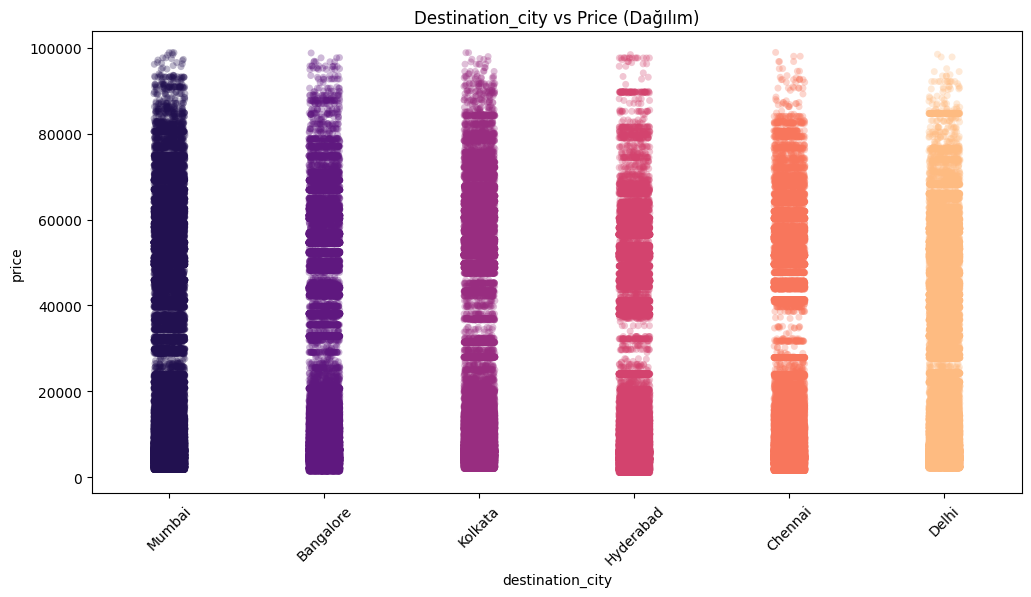

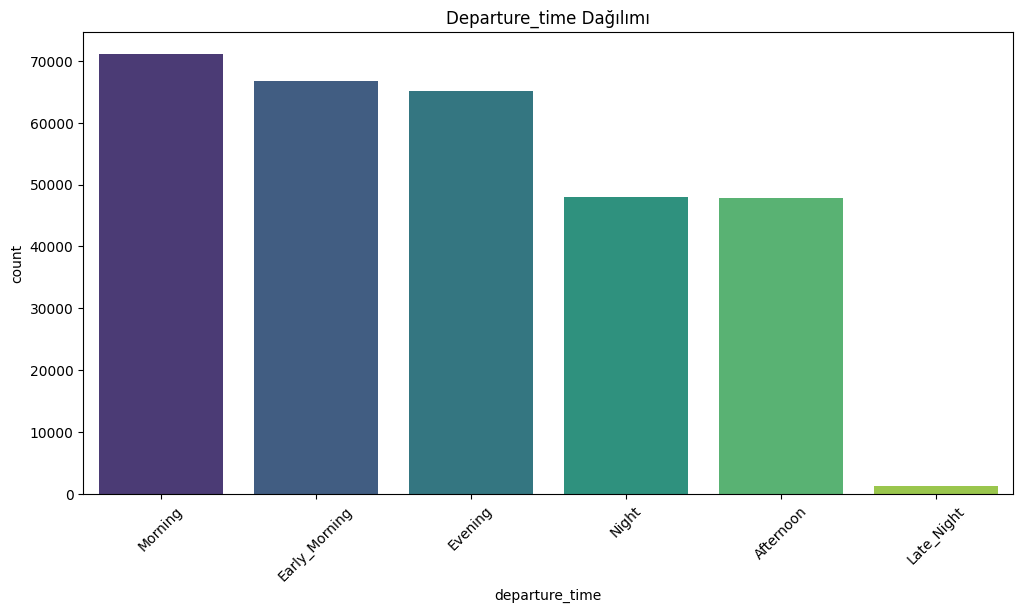

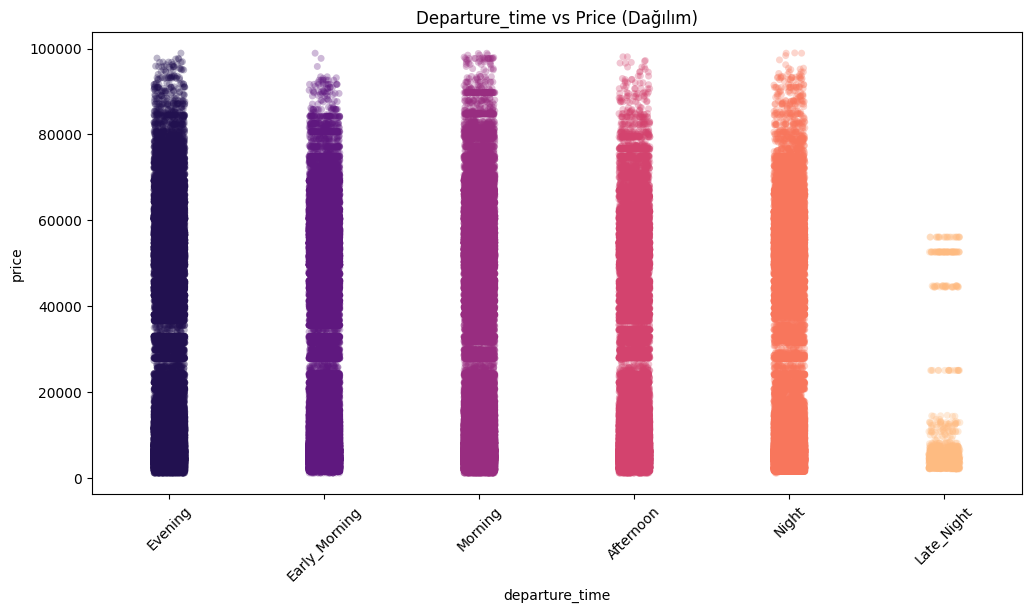

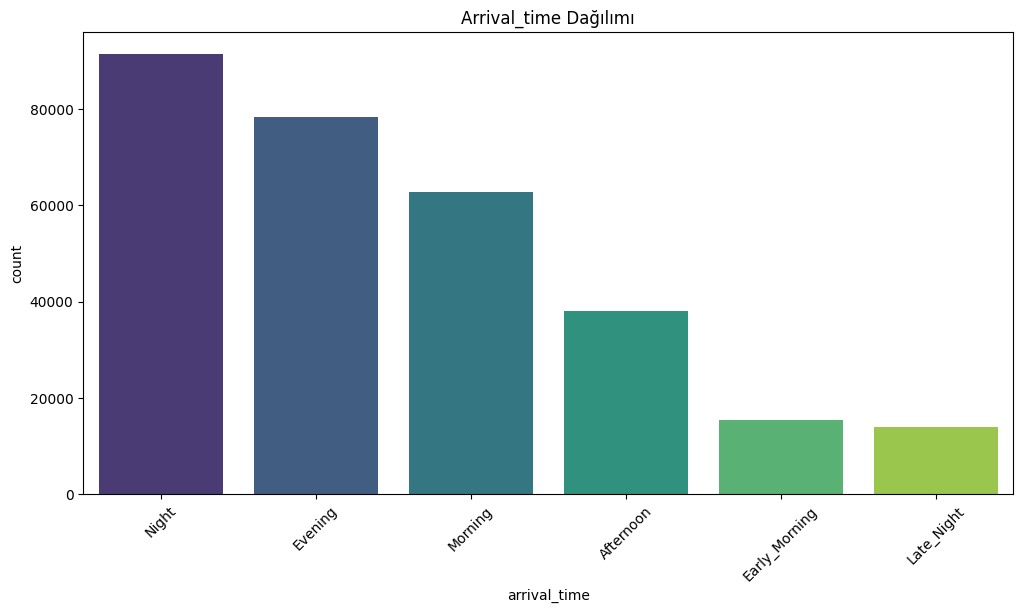

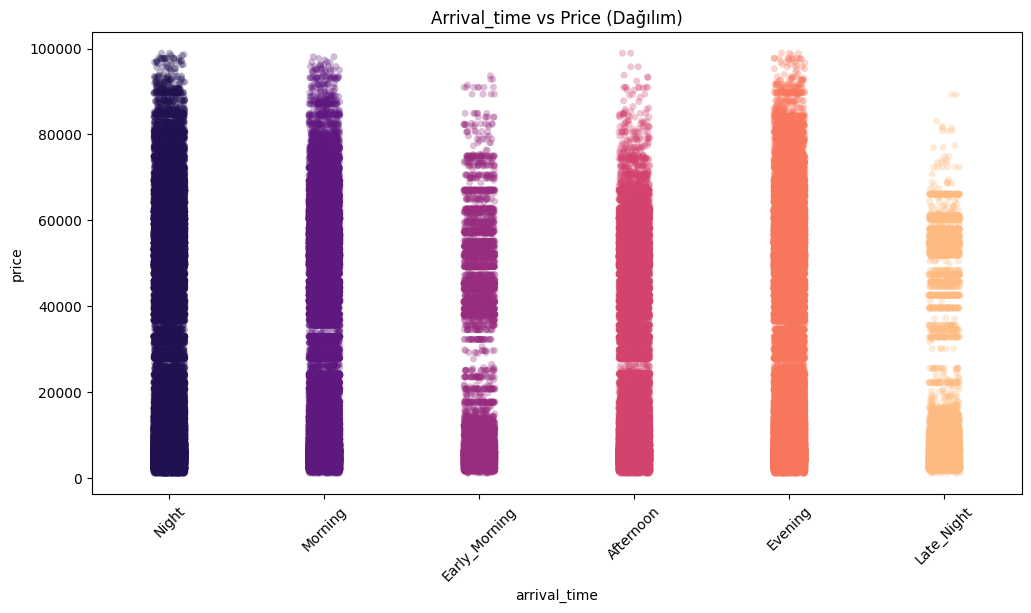

Görselleştirme tamamlandı.


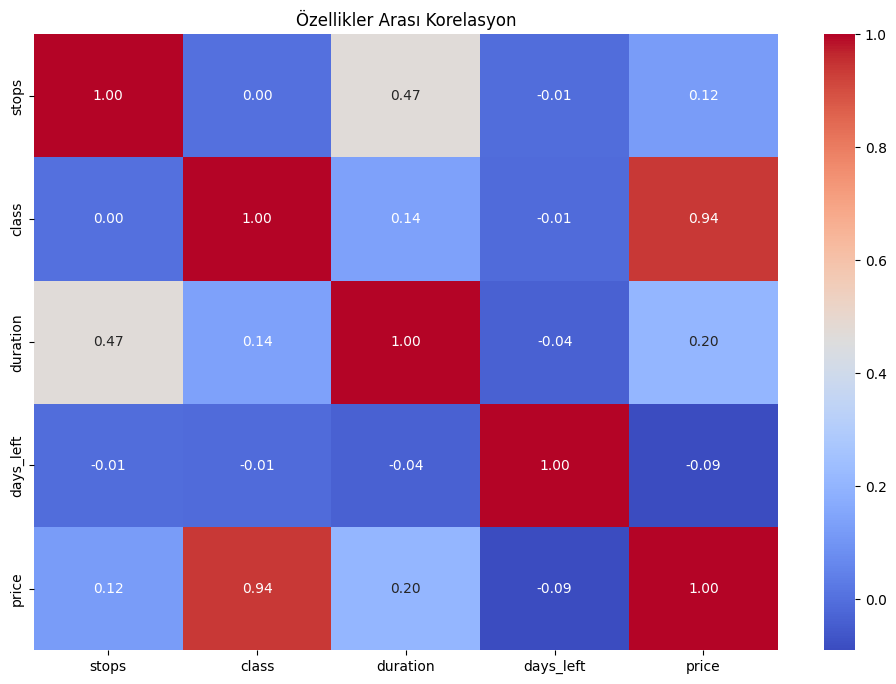


--- Feature Engineering (One-Hot & Scaling) ---
Feature Engineering Tamamlandı.
Eğitim Seti Boyutu: (240024, 29)

--- Modeller Eğitiliyor ---
Linear Regression -> RMSE: 6721.44, R2: 0.9115
Decision Tree -> RMSE: 3364.44, R2: 0.9778


[I 2025-11-23 14:45:25,746] A new study created in memory with name: no-name-b48074a0-cd19-4753-81fb-da0ede5ea0f5


KNN -> RMSE: 3782.47, R2: 0.9720

--- Hiperparametre Optimizasyonu Başlıyor ---
1. XGBoost Optimizasyonu...


[I 2025-11-23 14:45:35,784] Trial 0 finished with value: 3490.5837620661678 and parameters: {'n_estimators': 378, 'max_depth': 5, 'learning_rate': 0.28733288604166796, 'subsample': 0.5075263192405464, 'colsample_bytree': 0.6024133413096856}. Best is trial 0 with value: 3490.5837620661678.
[W 2025-11-23 14:45:37,992] Trial 1 failed with parameters: {'n_estimators': 373, 'max_depth': 8, 'learning_rate': 0.2820080016597739, 'subsample': 0.9533010744934789, 'colsample_bytree': 0.7766822972737859} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\menesnas\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\menesnas\AppData\Local\Temp\ipykernel_11596\3232493602.py", line 52, in objective_xgb
    model.fit(X_train, y_train)
  File "C:\Users\menesnas\AppData\Local\Programs\Python\Python312\Lib\site-

KeyboardInterrupt: 

In [10]:
# =============================================================================
# UÇAK BİLETİ FİYAT TAHMİNİ - TAM PROJE KODU (LEAKAGE FREE & OPTIMIZED)
# =============================================================================

# 1. GEREKLİ KÜTÜPHANELER
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap
import lime
import lime.lime_tabular
import warnings

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from IPython.display import display, HTML

# Uyarıları kapat
warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# GLOBAL DEĞİŞKENLER (Optuna fonksiyonları erişebilsin diye)
# ---------------------------------------------------------
X_train = None
X_test = None
y_train = None
y_test = None

# ---------------------------------------------------------
# OBJECTIVE FONKSİYONLARI (Optuna için)
# ---------------------------------------------------------
def objective_xgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    return np.sqrt(mse)

def objective_rf(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'n_jobs': -1,
        'random_state': 42
    }
    model = RandomForestRegressor(**param)
    # Cross Validation (Hız için cv=3)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error')
    return -scores.mean()

# ---------------------------------------------------------
# GÖRSELLEŞTİRME FONKSİYONU
# ---------------------------------------------------------
def detayli_gorsellestirme(df):
    print("\nGrafikler oluşturuluyor ve ekrana basılıyor...")
    
    # Sayısal Değişkenler
    numeric_cols = ['duration', 'days_left', 'stops', 'class']
    for col in numeric_cols:
        if col in df.columns:
            # Scatter Plot
            plt.figure(figsize=(10, 6))
            sns.scatterplot(data=df, x=col, y='price', alpha=0.6, color='teal')
            plt.title(f'{col.capitalize()} vs Price (Scatter Plot)')
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.show()

            # Histogram
            plt.figure(figsize=(10, 6))
            sns.histplot(data=df, x=col, kde=True, color='purple')
            plt.title(f'{col.capitalize()} Dağılımı (Histogram)')
            plt.show()

    # Kategorik Değişkenler
    categorical_cols = ['airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time']
    for col in categorical_cols:
        if col in df.columns:
            # Countplot
            plt.figure(figsize=(12, 6))
            sns.countplot(data=df, x=col, palette='viridis', order=df[col].value_counts().index)
            plt.title(f'{col.capitalize()} Dağılımı')
            plt.xticks(rotation=45)
            plt.show()
            
            # Strip Plot
            plt.figure(figsize=(12, 6))
            sns.stripplot(data=df, x=col, y='price', jitter=True, alpha=0.3, palette='magma')
            plt.title(f'{col.capitalize()} vs Price (Dağılım)')
            plt.xticks(rotation=45)
            plt.show()
    print("Görselleştirme tamamlandı.")

# =============================================================================
# ANA ÇALIŞMA BLOĞU (MAIN)
# =============================================================================
if __name__ == "__main__":
    
   # ---------------------------------------------------------
    # 1. VERİ YÜKLEME VE İLK BAKIŞ
    # ---------------------------------------------------------
    print("\n" + "="*50)
    print("1. ADIM: VERİ YÜKLEME")
    print("="*50)
    
    df = pd.read_csv('Clean_Dataset.csv')
    
    # DataFrame Terminal Çıktısı 1
    print("\n--- İlk 5 Satır ---")
    print(df.head())
    print("\n--- Veri Bilgisi (Info) ---")
    print(df.info())

    # ---------------------------------------------------------
    # 2. İSTATİSTİKSEL ANALİZ
    # ---------------------------------------------------------
    print("\n" + "="*50)
    print("2. ADIM: İSTATİSTİKSEL ANALİZ")
    print("="*50)
    
    # describe() ile istatistiksel özet
    print("\n--- Tanımlayıcı İstatistikler (Sayısal) ---")
    print(df.describe().T) # Transpose alarak daha okunaklı yaptık
    
    print("\n--- Kategorik Değişken Özetleri ---")
    print(df.describe(include=['O']).T)
    
    # Gereksiz kolonları at
    df = df.drop(['Unnamed: 0', 'flight'], axis=1)

    # Outlier (Aykırı Değer) Temizliği
    print("Aykırı değerler temizleniyor...")
    Q1 = df['price'].quantile(0.25)
    Q3 = df['price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_clean = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]
    print(f"Orijinal veri: {len(df)}, Temizlenmiş veri: {len(df_clean)}")

    # ---------------------------------------------------------
    # 2. ORDINAL MAPPING & GÖRSELLEŞTİRME
    # ---------------------------------------------------------
    # Hiyerarşisi olan verileri manuel map ediyoruz (Encoding öncesi)
    stops_mapping = {'zero': 0, 'one': 1, 'two_or_more': 2}
    class_mapping = {'Economy': 0, 'Business': 1}
    
    df_clean['stops'] = df_clean['stops'].map(stops_mapping)
    df_clean['class'] = df_clean['class'].map(class_mapping)

    # Detaylı Görselleştirme (One-Hot Öncesi)
    detayli_gorsellestirme(df_clean)

    # Korelasyon Matrisi
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_clean.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Özellikler Arası Korelasyon")
    plt.show()

    # ---------------------------------------------------------
    # 3. FEATURE ENGINEERING & SPLIT (LEAKAGE-FREE YÖNTEM)
    # ---------------------------------------------------------
    print("\n--- Feature Engineering (One-Hot & Scaling) ---")
    
    # A. Önce X ve y'yi ayırıyoruz
    X = df_clean.drop('price', axis=1)
    y = df_clean['price']

    # B. Train/Test Split (EN BAŞTA)
    # Global değişkenlere atıyoruz
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # İşlenecek kolonları belirle
    nominal_cols = ['airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time']
    numerical_cols = ['duration', 'days_left', 'stops', 'class']

    # C. One-Hot Encoding (Sadece Train'e fit et)
    ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    ohe.fit(X_train_raw[nominal_cols])

    # Dönüştürme
    X_train_ohe = ohe.transform(X_train_raw[nominal_cols])
    X_test_ohe = ohe.transform(X_test_raw[nominal_cols])

    # DataFrame'e geri çevirme
    ohe_cols = ohe.get_feature_names_out(nominal_cols)
    X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=ohe_cols, index=X_train_raw.index)
    X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=ohe_cols, index=X_test_raw.index)

    # D. Birleştirme
    X_train_final = pd.concat([X_train_raw[numerical_cols], X_train_ohe_df], axis=1)
    X_test_final = pd.concat([X_test_raw[numerical_cols], X_test_ohe_df], axis=1)

    # E. Normalizasyon (Sadece Train'e fit et)
    scaler = MinMaxScaler()
    scaler.fit(X_train_final)

    # Dönüştürme
    X_train = pd.DataFrame(scaler.transform(X_train_final), columns=X_train_final.columns)
    X_test = pd.DataFrame(scaler.transform(X_test_final), columns=X_test_final.columns)
    
    print("Feature Engineering Tamamlandı.")
    print(f"Eğitim Seti Boyutu: {X_train.shape}")

    # SVR için küçük subset oluşturma
    X_train_sub = X_train.iloc[:10000]
    y_train_sub = y_train.iloc[:10000]

    # ---------------------------------------------------------
    # 4. MODEL SEÇİMİ VE EĞİTİM
    # ---------------------------------------------------------
    models = {
        "Linear Regression": LinearRegression(),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        # "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
        # "XGBoost": XGBRegressor(random_state=42, n_jobs=-1),
        "KNN": KNeighborsRegressor(n_neighbors=5, n_jobs=-1),
        # "SVR": SVR(kernel='rbf') 
    }

    results = {}
    print("\n--- Modeller Eğitiliyor ---")
    
    for name, model in models.items():
        if name == "SVR":
            print(f"{name} eğitiliyor (Hız için 10.000 veri ile)...")
            model.fit(X_train_sub, y_train_sub)
        else:
            model.fit(X_train, y_train)
            
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results[name] = {"RMSE": rmse, "R2 Score": r2}
        print(f"{name} -> RMSE: {rmse:.2f}, R2: {r2:.4f}")

    # ---------------------------------------------------------
    # 5. HİPERPARAMETRE OPTİMİZASYONU (OPTUNA)
    # ---------------------------------------------------------
    print("\n--- Hiperparametre Optimizasyonu Başlıyor ---")

    # XGBoost
    print("1. XGBoost Optimizasyonu...")
    study_xgb = optuna.create_study(direction='minimize')
    study_xgb.optimize(objective_xgb, n_trials=10) 
    print('XGBoost En İyi:', study_xgb.best_params)
    
    best_xgb = XGBRegressor(**study_xgb.best_params, n_jobs=-1, random_state=42)
    best_xgb.fit(X_train, y_train)

    # Random Forest
    print("\n2. Random Forest Optimizasyonu...")
    study_rf = optuna.create_study(direction='minimize')
    study_rf.optimize(objective_rf, n_trials=5) # RF yavaştır, az deneme
    print('Random Forest En İyi:', study_rf.best_params)

    best_rf = RandomForestRegressor(**study_rf.best_params, n_jobs=-1, random_state=42)
    best_rf.fit(X_train, y_train)

    # ---------------------------------------------------------
    # 6. FİNAL KARŞILAŞTIRMA VE XAI SEÇİMİ
    # ---------------------------------------------------------
    y_pred_xgb_opt = best_xgb.predict(X_test)
    y_pred_rf_opt = best_rf.predict(X_test)

    r2_xgb = r2_score(y_test, y_pred_xgb_opt)
    r2_rf = r2_score(y_test, y_pred_rf_opt)

    print(f"\nOptimize XGBoost R2: {r2_xgb:.4f}")
    print(f"Optimize Random Forest R2: {r2_rf:.4f}")

    if r2_xgb > r2_rf:
        print("Kazanan Model: XGBoost (Analiz edilecek)")
        final_model = best_xgb
    else:
        print("Kazanan Model: Random Forest (Analiz edilecek)")
        final_model = best_rf

    # ---------------------------------------------------------
    # 7. AÇIKLANABİLİR YAPAY ZEKA (SHAP & LIME)
    # ---------------------------------------------------------
    print("\nSHAP Analizi (İlk 100 veri)...")
    explainer = shap.Explainer(final_model)
    shap_values = explainer(X_test[:100])
    
    plt.figure()
    shap.summary_plot(shap_values, X_test[:100])

    print("\nLIME Analizi (Rastgele bir örnek)...")
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=np.array(X_train),
        feature_names=X_train.columns,
        class_names=['price'],
        mode='regression'
    )
    
    # Notebook'ta güzel görünmesi için stil
    display(HTML("<style>.lime {color: #00ffea !important;} .lime table, .lime td, .lime th {color: #ffcc00 !important; background-color: #222 !important;}</style>"))
    
    exp = lime_explainer.explain_instance(
        data_row=np.array(X_test.iloc[0]), 
        predict_fn=final_model.predict
    )
    exp.show_in_notebook(show_table=True)

    # ---------------------------------------------------------
    # 8. SONUÇ RAPORLAMA
    # ---------------------------------------------------------
    results_df = pd.DataFrame(results).T
    print("\n--- Genel Model Sonuçları ---")
    print(results_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=results_df.index, y=results_df['R2 Score'])
    plt.title('Modellerin Başarı Karşılaştırması')
    plt.xticks(rotation=45)
    plt.show()
